In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
from keras import ops
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Sampling layer adapted from Keras VAE tutorial
# Source: https://keras.io/examples/generative/vae/
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, kl_weight=0.5, **kwargs):
        super().__init__(**kwargs)
        self.kl_weight = kl_weight
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(self.kl_weight * kl_loss)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ service             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protocol            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 16)     │      1,120 │ service[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flag (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding   │ (None, 3)         │          0 │ protocol[0][0]    │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding_1 │ (None, 11)        │          0 │ flag[0][0]        │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary (InputLayer) │ (None, 4)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ real (InputLayer)   │ (None, 36)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 70)        │          0 │ category_encodin… │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ category_encodin… │
│                     │                   │            │ binary[0][0],     │
│                     │                   │            │ real[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,544 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,340 (32.58 KB)

 Trainable params: 8,340 (32.58 KB)

 Non-trainable params: 0 (0.00 B)

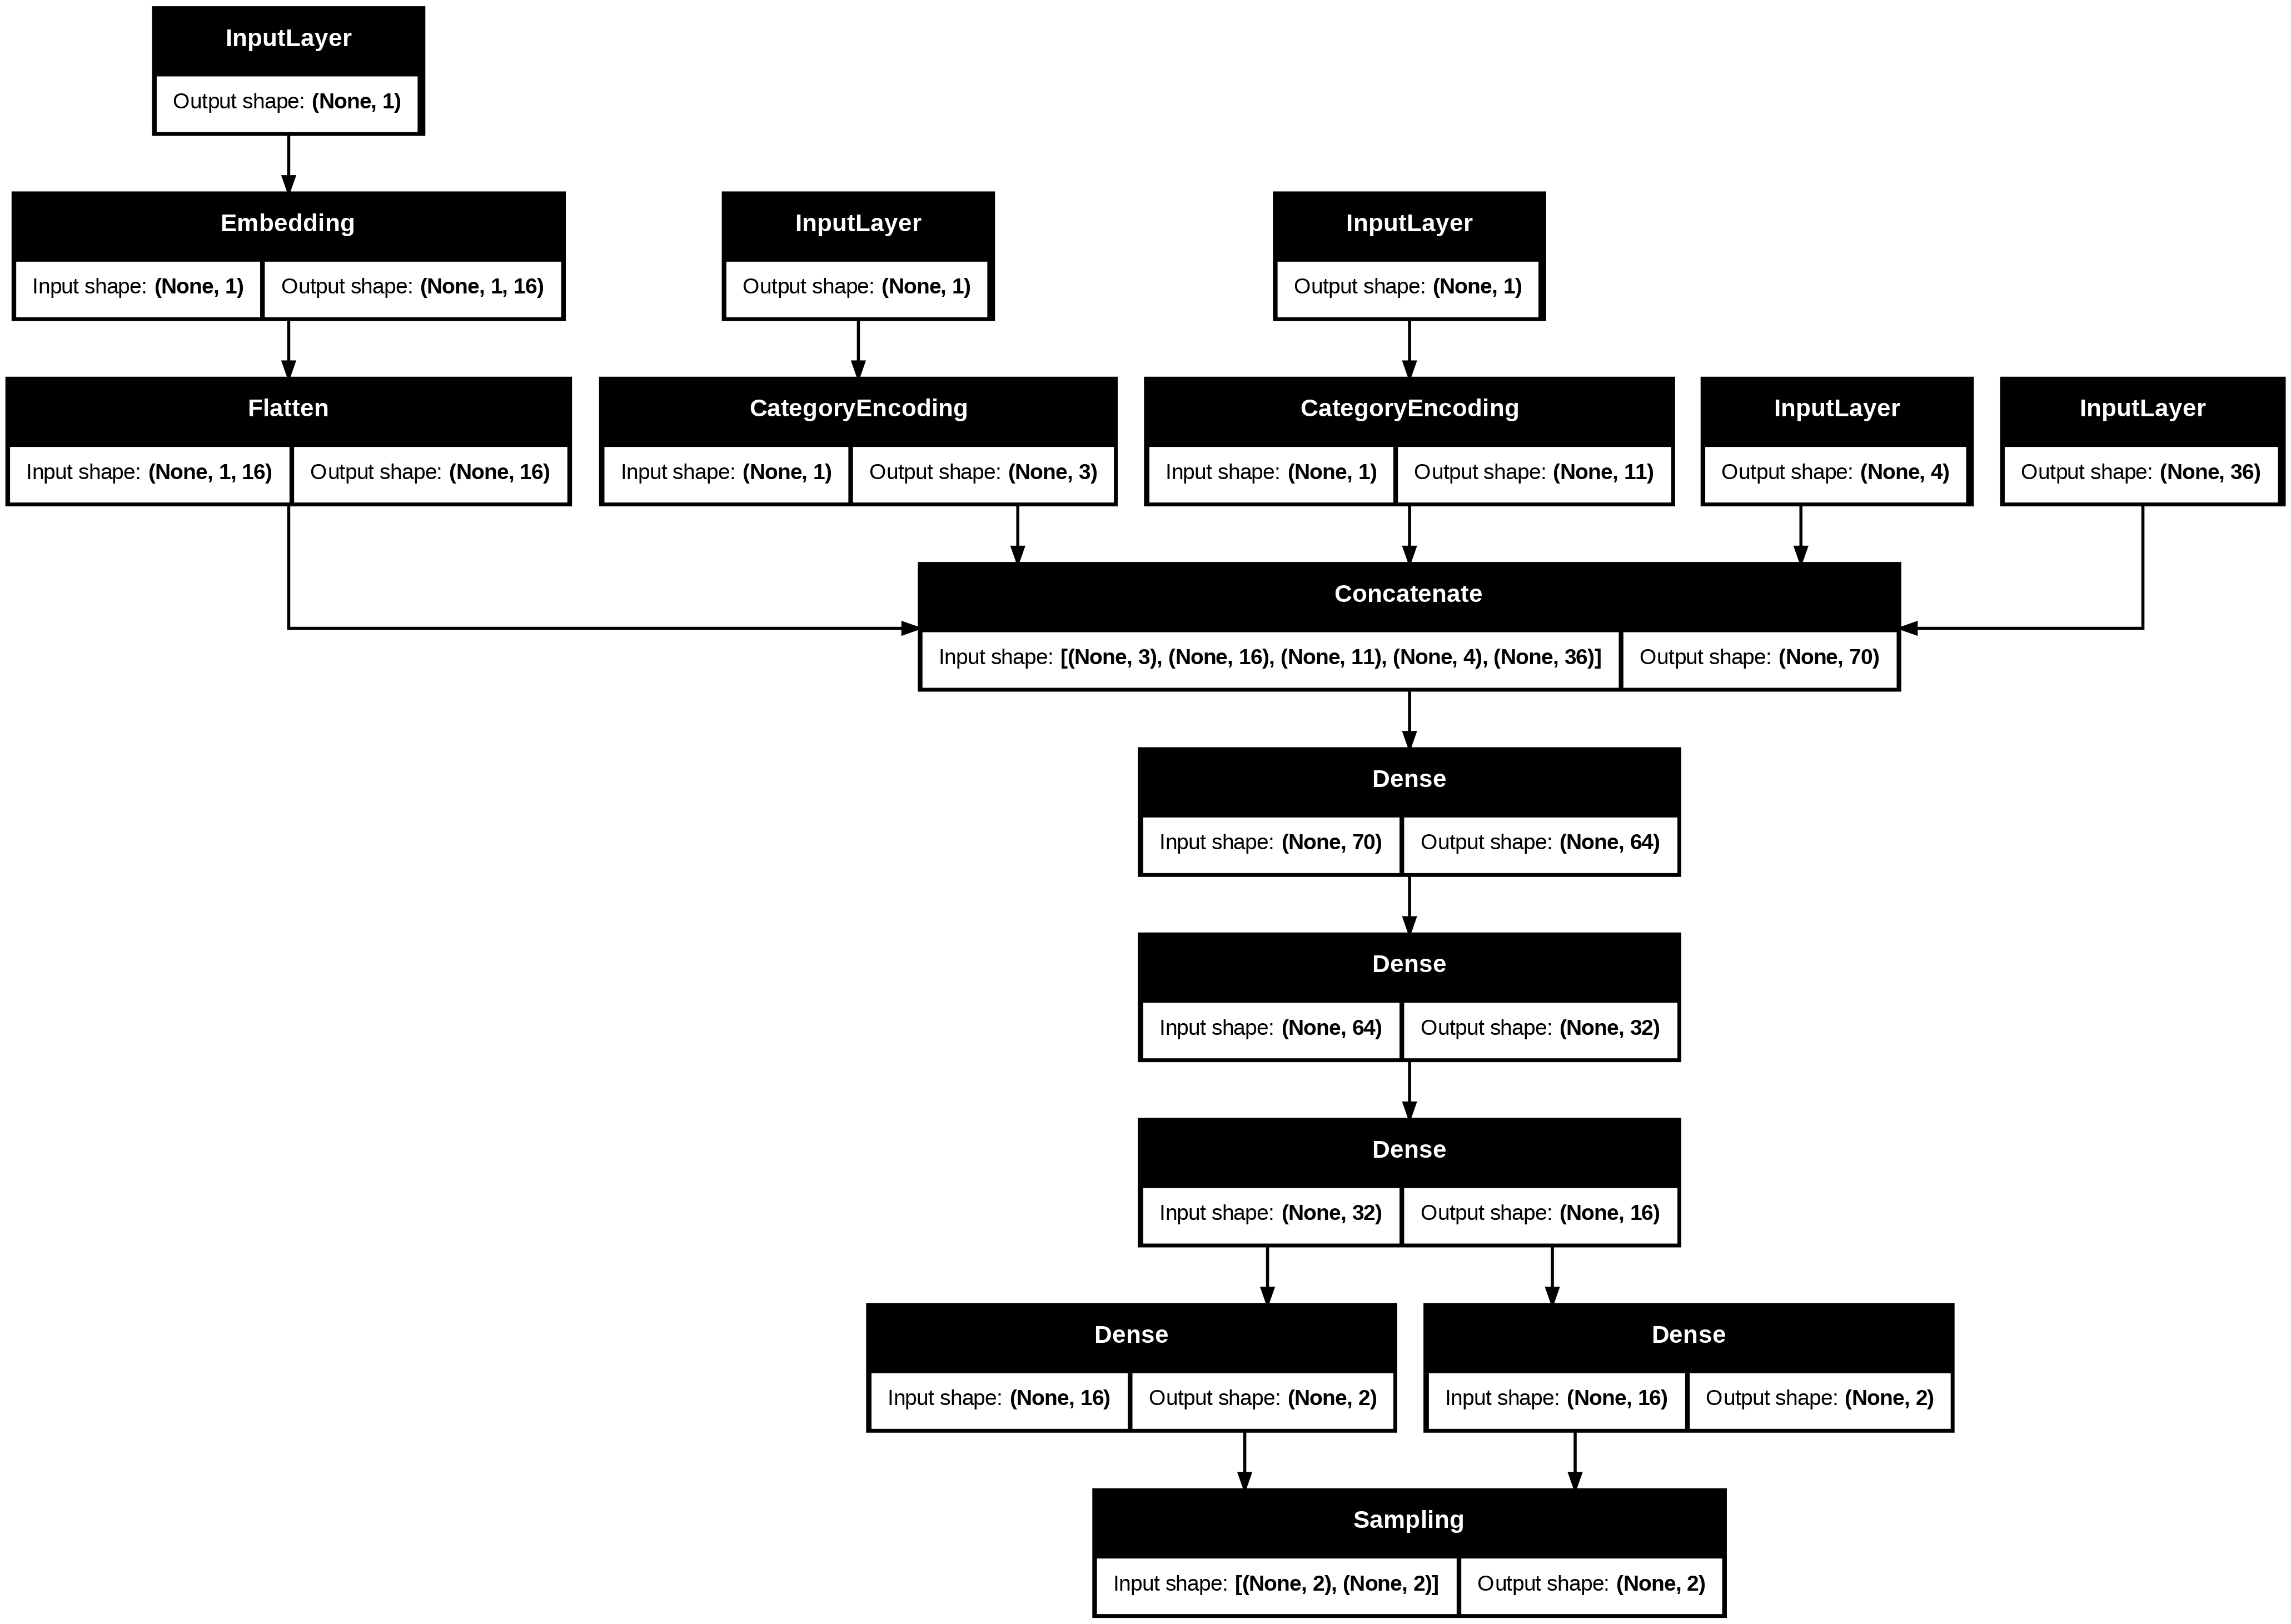

In [3]:
latent_dim = 2

service_input = keras.Input(shape=(1,), name="service")
protocol_input = keras.Input(shape=(1,), name="protocol")
flag_input = keras.Input(shape=(1,), name="flag")
binary_input = keras.Input(shape=(4,), name="binary")
real_input = keras.Input(shape=(36,), name="real")

service_embedding = layers.Flatten()(layers.Embedding(70, 16)(service_input))
protocol_one_hot = layers.CategoryEncoding(num_tokens=3, output_mode="one_hot")(protocol_input)
flag_one_hot = layers.CategoryEncoding(num_tokens=11, output_mode="one_hot")(flag_input)

concat_input = layers.Concatenate()([protocol_one_hot, service_embedding, flag_one_hot, binary_input, real_input])

x = layers.Dense(64, activation="relu")(concat_input)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling(kl_weight=0.1)([z_mean, z_log_var])
encoder = keras.Model(inputs=[service_input, protocol_input, flag_input, binary_input, real_input], outputs={"z_mean": z_mean, "z_log_var": z_log_var, "z": z}, name="encoder")
encoder.summary()
keras.utils.plot_model(encoder, "encoder.png", show_shapes=True)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │         48 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │        544 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      2,112 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │        260 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 11)        │        715 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │        195 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 36)        │      2,340 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 70)        │      4,550 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,764 (42.05 KB)

 Trainable params: 10,764 (42.05 KB)

 Non-trainable params: 0 (0.00 B)

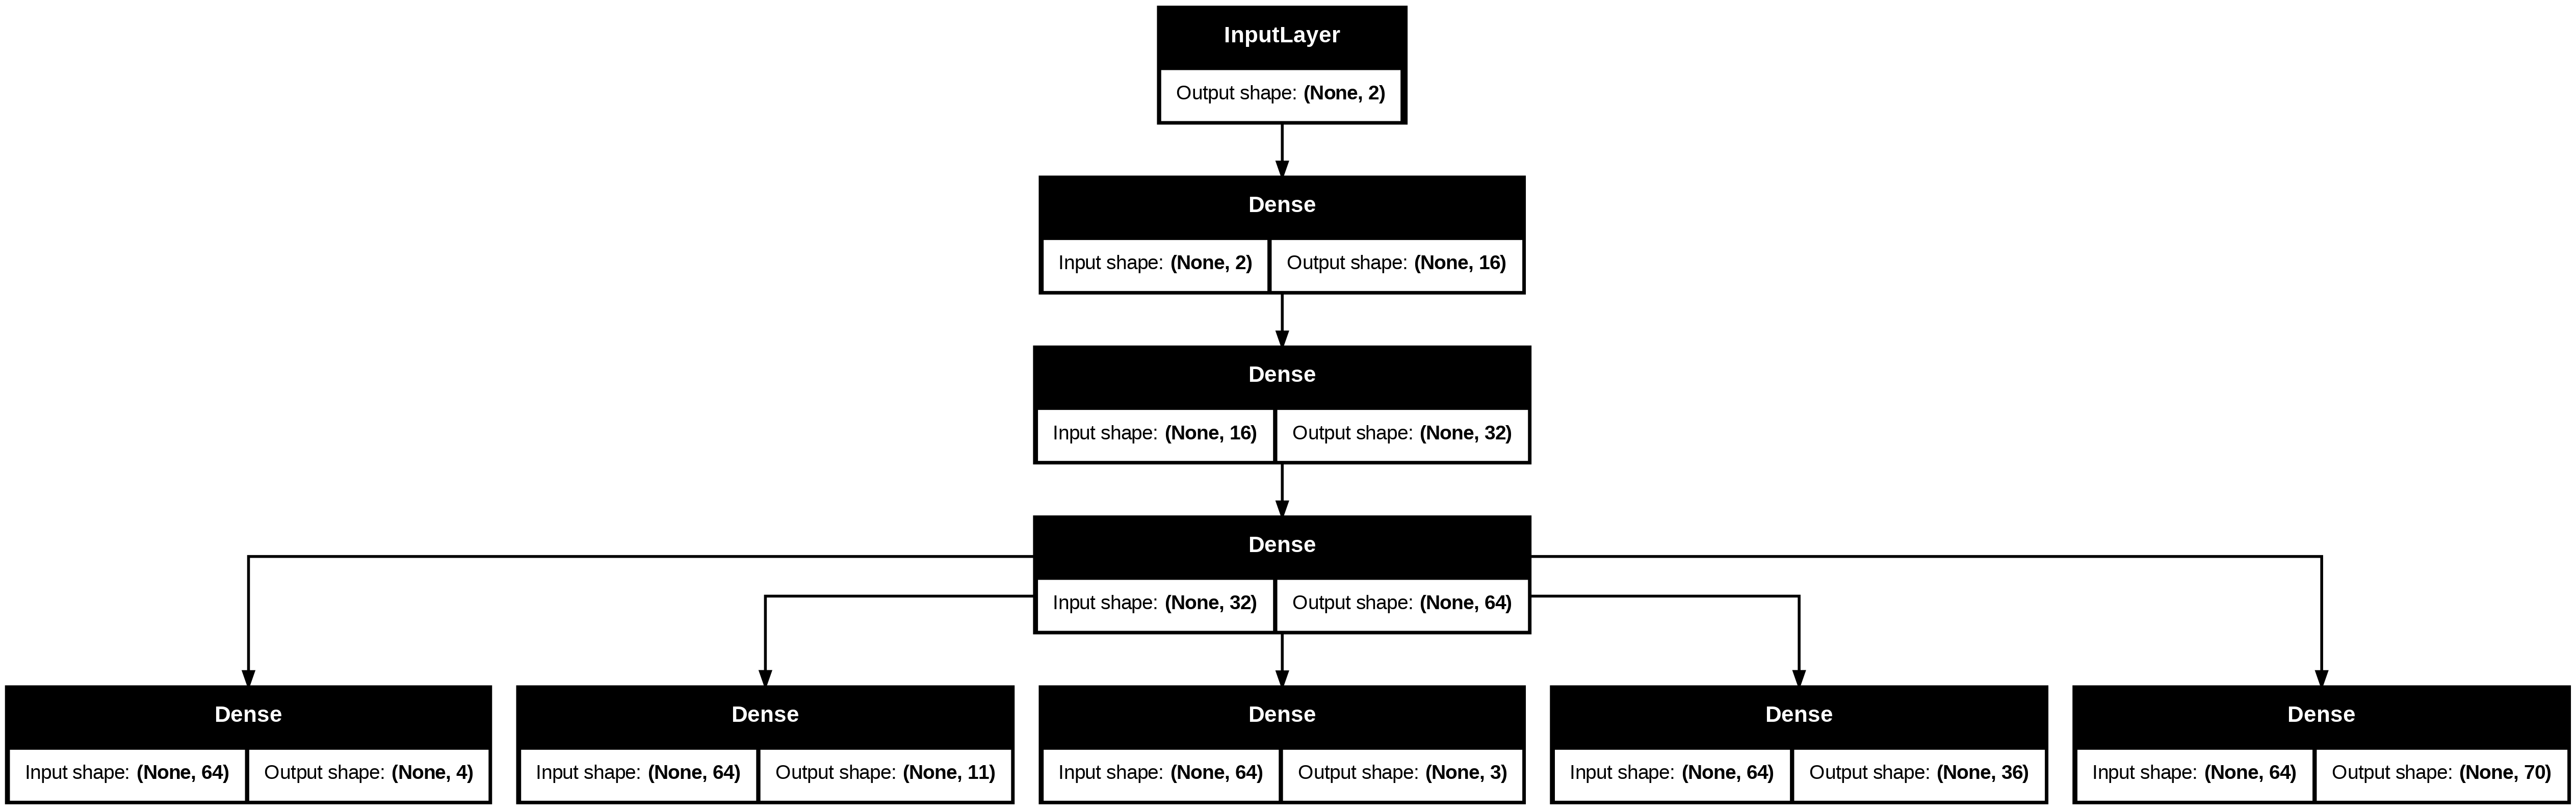

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)

service_logits = layers.Dense(70, activation=None)(x)
protocol_logits = layers.Dense(3, activation=None)(x)
flag_logits = layers.Dense(11, activation=None)(x)
binary_logits = layers.Dense(4, activation="sigmoid")(x)
real_logits = layers.Dense(36, activation=None)(x)

decoder = keras.Model(
    latent_inputs,
    outputs={"service_logits": service_logits,
             "protocol_logits": protocol_logits,
             "flag_logits": flag_logits,
             "binary_logits": binary_logits,
             "real_logits": real_logits},
    name="decoder")
decoder.summary()
keras.utils.plot_model(decoder, "decoder.png", show_shapes=True)

In [5]:
class ReconstructionError(layers.Layer):

    def __init__(self, loss_weights, **kwargs):
        super().__init__(**kwargs)
        self.loss_weights = loss_weights

    def call(self, inputs):
        service_error = ops.sparse_categorical_crossentropy(
            inputs['service_true'],
            inputs['service_pred'],
            from_logits=True
        )

        protocol_error = ops.sparse_categorical_crossentropy(
            inputs['protocol_true'],
            inputs['protocol_pred'],
            from_logits=True
        )

        flag_error = ops.sparse_categorical_crossentropy(
            inputs['flag_true'],
            inputs['flag_pred'],
            from_logits=True
        )

        binary_error = ops.sum(
            ops.binary_crossentropy(
                inputs['binary_true'],
                inputs['binary_pred']
            ),
            axis=-1
        )

        real_error = ops.mean(
            ops.square(inputs['real_true'] - inputs['real_pred']),
            axis=-1
        )

        total_error = (
            self.loss_weights['service'] * service_error +
            self.loss_weights['protocol'] * protocol_error +
            self.loss_weights['flag'] * flag_error +
            self.loss_weights['binary'] * binary_error +
            self.loss_weights['real'] * real_error
        )

        return total_error


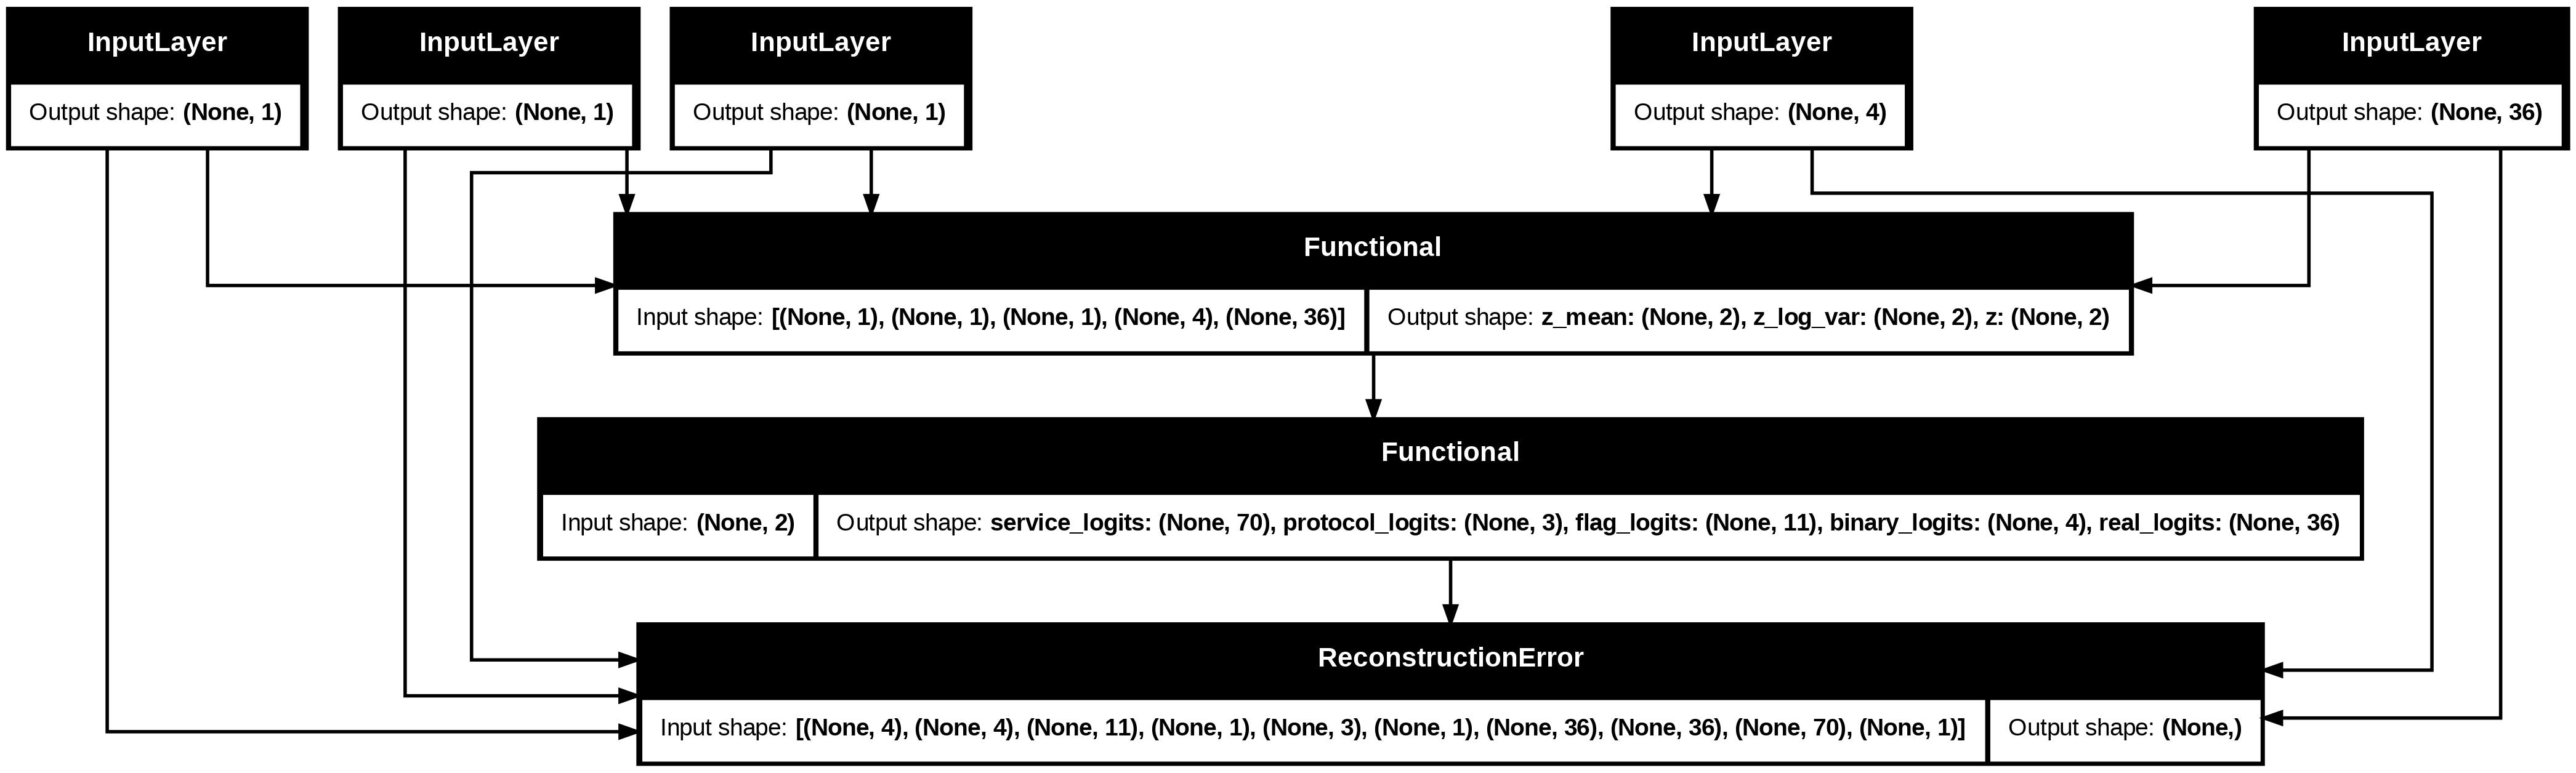

In [16]:
service_input = keras.Input(shape=(1,), name="service")
protocol_input = keras.Input(shape=(1,), name="protocol")
flag_input = keras.Input(shape=(1,), name="flag")
binary_input = keras.Input(shape=(4,), name="binary")
real_input = keras.Input(shape=(36,), name="real")

encoder_output = encoder([service_input, protocol_input, flag_input, binary_input, real_input])
decoder_output = decoder(encoder_output["z"])

loss_weights_dict = {
    'service': 2.0,
    'protocol': 1.5,
    'flag': 1.5,
    'binary': 3.0,
    'real': 1.0
}

recon_error = ReconstructionError(loss_weights_dict)({
    'service_true': service_input,
    'service_pred': decoder_output["service_logits"],
    'protocol_true': protocol_input,
    'protocol_pred': decoder_output["protocol_logits"],
    'flag_true': flag_input,
    'flag_pred': decoder_output["flag_logits"],
    'binary_true': binary_input,
    'binary_pred': decoder_output["binary_logits"],
    'real_true': real_input,
    'real_pred': decoder_output["real_logits"]
})

autoencoder = keras.Model(
    inputs=[service_input, protocol_input, flag_input, binary_input, real_input],
    outputs={
       "service_logits": decoder_output["service_logits"],
        "protocol_logits": decoder_output["protocol_logits"],
        "flag_logits": decoder_output["flag_logits"],
        "binary_logits": decoder_output["binary_logits"],
        "real_logits": decoder_output["real_logits"],

        "z_mean": encoder_output["z_mean"],
        "z_log_var": encoder_output["z_log_var"],
        "z": encoder_output["z"],

        "reconstruction_error": recon_error
    },
    name="autoencoder"
)

autoencoder.compile(
    optimizer="adam",
    loss={
        "service_logits": keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        "protocol_logits": keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        "flag_logits": keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        "binary_logits": keras.losses.BinaryCrossentropy(from_logits=False),
        "real_logits": keras.losses.MeanSquaredError()
    },
    loss_weights={
        "service_logits": 2.0,
        "protocol_logits": 1.5,
        "flag_logits": 1.5,
        "binary_logits": 3.0,
        "real_logits": 1.0
    }
)

keras.utils.plot_model(autoencoder, "autoencoder.png", show_shapes=True)

In [7]:
df_train = pd.read_csv("KDDTrain+.txt", header=None)

proto_map = {}
for (i, val) in enumerate(df_train[1].unique()):
  proto_map[val] = i

service_map = {}
for (i, val) in enumerate(df_train[2].unique()):
  service_map[val] = i

flag_map = {}
for (i, val) in enumerate(df_train[3].unique()):
  flag_map[val] = i

def format_data(df, proto_map=proto_map, service_map=service_map, flag_map=flag_map, batch_size=32):

  rates = df[[6,11,13,19,24,25,26,27,28,29,32,33,34,35,36,37,38,39,40]]
  log_standardized = df[[0,4,5,7,8,9,10,12,14,15,16,17,18,22,23,30,31]].copy()

  log_standardized = np.log1p(log_standardized)

  scaler = StandardScaler()
  log_standardized_scaled = scaler.fit_transform(log_standardized)

  log_standardized = pd.DataFrame(
    log_standardized_scaled,
    columns=log_standardized.columns,
    index=log_standardized.index
  )

  real = pd.concat([rates, log_standardized], axis=1)

  inputs = {
      'service': df[2].map(service_map).values.reshape(-1, 1).astype(np.float32),
      'protocol': df[1].map(proto_map).values.reshape(-1, 1).astype(np.float32),
      'flag': df[3].map(flag_map).values.reshape(-1, 1).astype(np.float32),
      'binary': df[[6,11,20,21]].values.astype(np.float32),
      'real': real.values.astype(np.float32)
  }

  targets = {
      'service_logits': df[2].map(service_map).values.astype(np.int32),
      'protocol_logits': df[1].map(proto_map).values.astype(np.int32),
      'flag_logits': df[3].map(flag_map).values.astype(np.int32),
      'binary_logits': df[[6,11,20,21]].values.astype(np.float32),
      'real_logits': real.values.astype(np.float32)
  }

  dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

In [8]:
def get_reconstruction_error(model, data):
    predictions = model.predict(data, verbose=0)
    return predictions['reconstruction_error']

class AnomalyDetectionCallback(keras.callbacks.Callback):
    def __init__(self, val_normal_dataset, val_attack_dataset):
        super().__init__()
        self.val_normal_dataset = val_normal_dataset
        self.val_attack_dataset = val_attack_dataset
        self.auroc_history = []

    def on_epoch_end(self, epoch, logs=None):
        normal_errors = get_reconstruction_error(self.model, self.val_normal_dataset)
        attack_errors = get_reconstruction_error(self.model, self.val_attack_dataset)

        y_true = np.concatenate([
            np.zeros(len(normal_errors)),
            np.ones(len(attack_errors))
        ])
        y_scores = np.concatenate([normal_errors, attack_errors])

        auroc = roc_auc_score(y_true, y_scores)
        self.auroc_history.append(auroc)

        logs['val_auroc'] = auroc
        print(f" - val_auroc: {auroc:.4f}")

        0    1         2   3     4     5   6   7   8   9   ...    33    34  \
0        0  tcp  ftp_data  SF   491     0   0   0   0   0  ...  0.17  0.03   
1        0  udp     other  SF   146     0   0   0   0   0  ...  0.00  0.60   
3        0  tcp      http  SF   232  8153   0   0   0   0  ...  1.00  0.00   
4        0  tcp      http  SF   199   420   0   0   0   0  ...  1.00  0.00   
12       0  tcp      http  SF   287  2251   0   0   0   0  ...  1.00  0.00   
...     ..  ...       ...  ..   ...   ...  ..  ..  ..  ..  ...   ...   ...   
125965   0  tcp      smtp  SF  2233   365   0   0   0   0  ...  1.00  0.00   
125967   0  tcp      http  SF   359   375   0   0   0   0  ...  1.00  0.00   
125969   8  udp   private  SF   105   145   0   0   0   0  ...  0.96  0.01   
125970   0  tcp      smtp  SF  2231   384   0   0   0   0  ...  0.12  0.06   
125972   0  tcp  ftp_data  SF   151     0   0   0   0   0  ...  0.30  0.03   

          35    36    37    38    39    40      41  42  
0     

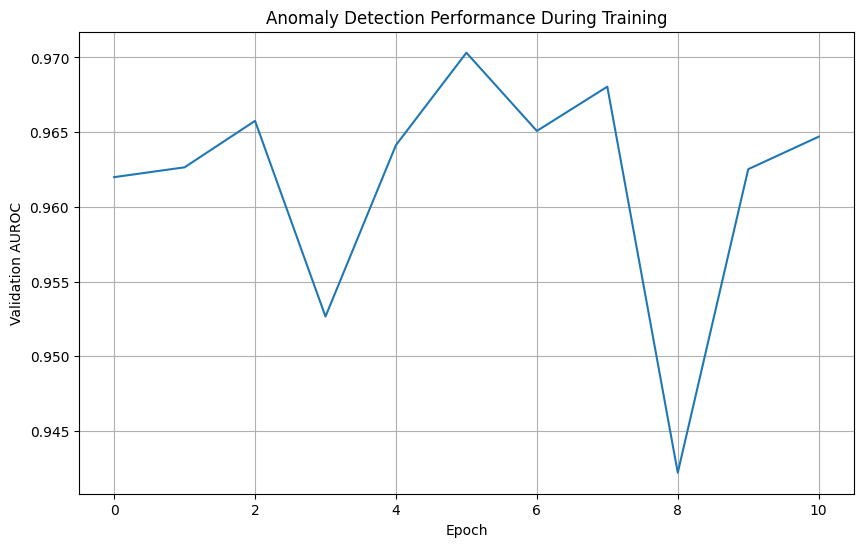

In [9]:
df_train = df_train[df_train[41] == 'normal']
df_test = pd.read_csv("KDDTest+.txt", header=None)
df_val_normal = df_test[df_test[41] == 'normal'].sample(1000, random_state=42)
df_val_attacks = df_test[df_test[41] != 'normal'].sample(1000, random_state=42)

val_normal_dataset = format_data(df_val_normal, batch_size=32)
val_attack_dataset = format_data(df_val_attacks, batch_size=32)

print(df_train)

auroc_callback = AnomalyDetectionCallback(val_normal_dataset, val_attack_dataset)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auroc',
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

autoencoder.fit(
    format_data(df_train, proto_map, service_map, flag_map),
    epochs=100,
    callbacks=[auroc_callback, early_stopping],
)

plt.figure(figsize=(10, 6))
plt.plot(auroc_callback.auroc_history)
plt.xlabel('Epoch')
plt.ylabel('Validation AUROC')
plt.title('Anomaly Detection Performance During Training')
plt.grid(True)
plt.show()

In [14]:
autoencoder.save('vae_nids_model.keras')

In [10]:
df_test = pd.read_csv("KDDTest+.txt", header=None)

df_val_normal = df_test[df_test[41] == 'normal']
df_val_attacks = df_test[df_test[41] != 'normal']

normal_errors = get_reconstruction_error(autoencoder, format_data(df_val_normal))
attack_errors = get_reconstruction_error(autoencoder, format_data(df_val_attacks))

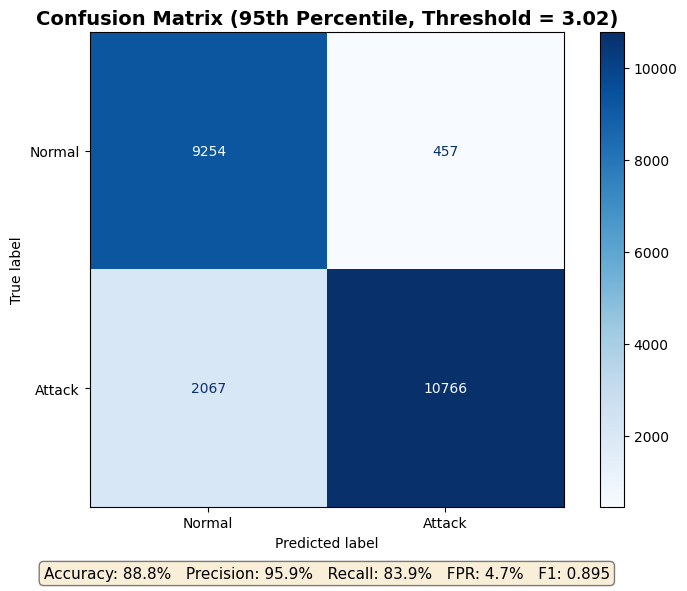

In [11]:
train_normal_errors = get_reconstruction_error(
    autoencoder,
    format_data(df_train)
)

threshold = np.percentile(train_normal_errors, 95)

normal_predictions = (normal_errors > threshold).astype(int)
attack_predictions = (attack_errors > threshold).astype(int)

y_true = np.concatenate([
    np.zeros(len(normal_errors)),
    np.ones(len(attack_errors))
])

y_pred = np.concatenate([
    normal_predictions,
    attack_predictions
])

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title(f'Confusion Matrix (95th Percentile, Threshold = {threshold:.2f})', fontsize=14, fontweight='bold')

TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
fpr = FP / (FP + TN)
f1 = 2 * precision * recall / (precision + recall)

metrics_text = (
    f'Accuracy: {accuracy:.1%}   Precision: {precision:.1%}   '
    f'Recall: {recall:.1%}   FPR: {fpr:.1%}   F1: {f1:.3f}'
)
plt.text(0.5, -0.15, metrics_text, ha='center', transform=ax.transAxes, fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('confusion_matrix_95th.png', dpi=150, bbox_inches='tight')
plt.show()

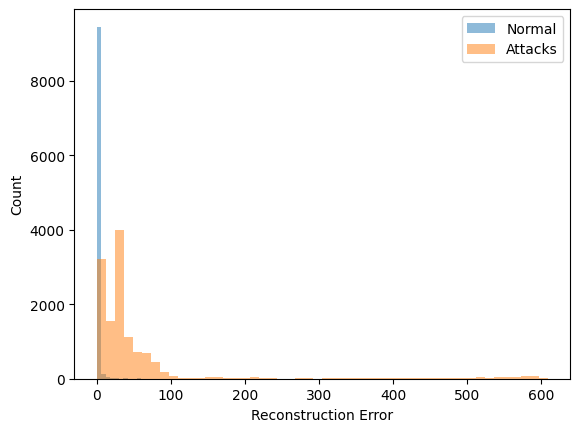

In [12]:

plt.hist(normal_errors, alpha=0.5, label='Normal', bins=50)
plt.hist(attack_errors, alpha=0.5, label='Attacks', bins=50)
plt.legend()
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.show()

Latent space shape: (3481, 2)
Number of samples: 3481
Attack types: ['apache2' 'back' 'buffer_overflow' 'ftp_write' 'guess_passwd'
 'httptunnel' 'imap' 'ipsweep' 'land' 'loadmodule' 'mailbomb' 'mscan'
 'multihop' 'named' 'neptune' 'nmap' 'normal' 'perl' 'phf' 'pod'
 'portsweep' 'processtable' 'ps' 'rootkit' 'saint' 'satan' 'sendmail'
 'smurf' 'snmpgetattack' 'snmpguess' 'sqlattack' 'teardrop' 'udpstorm'
 'warezmaster' 'worm' 'xlock' 'xsnoop' 'xterm']


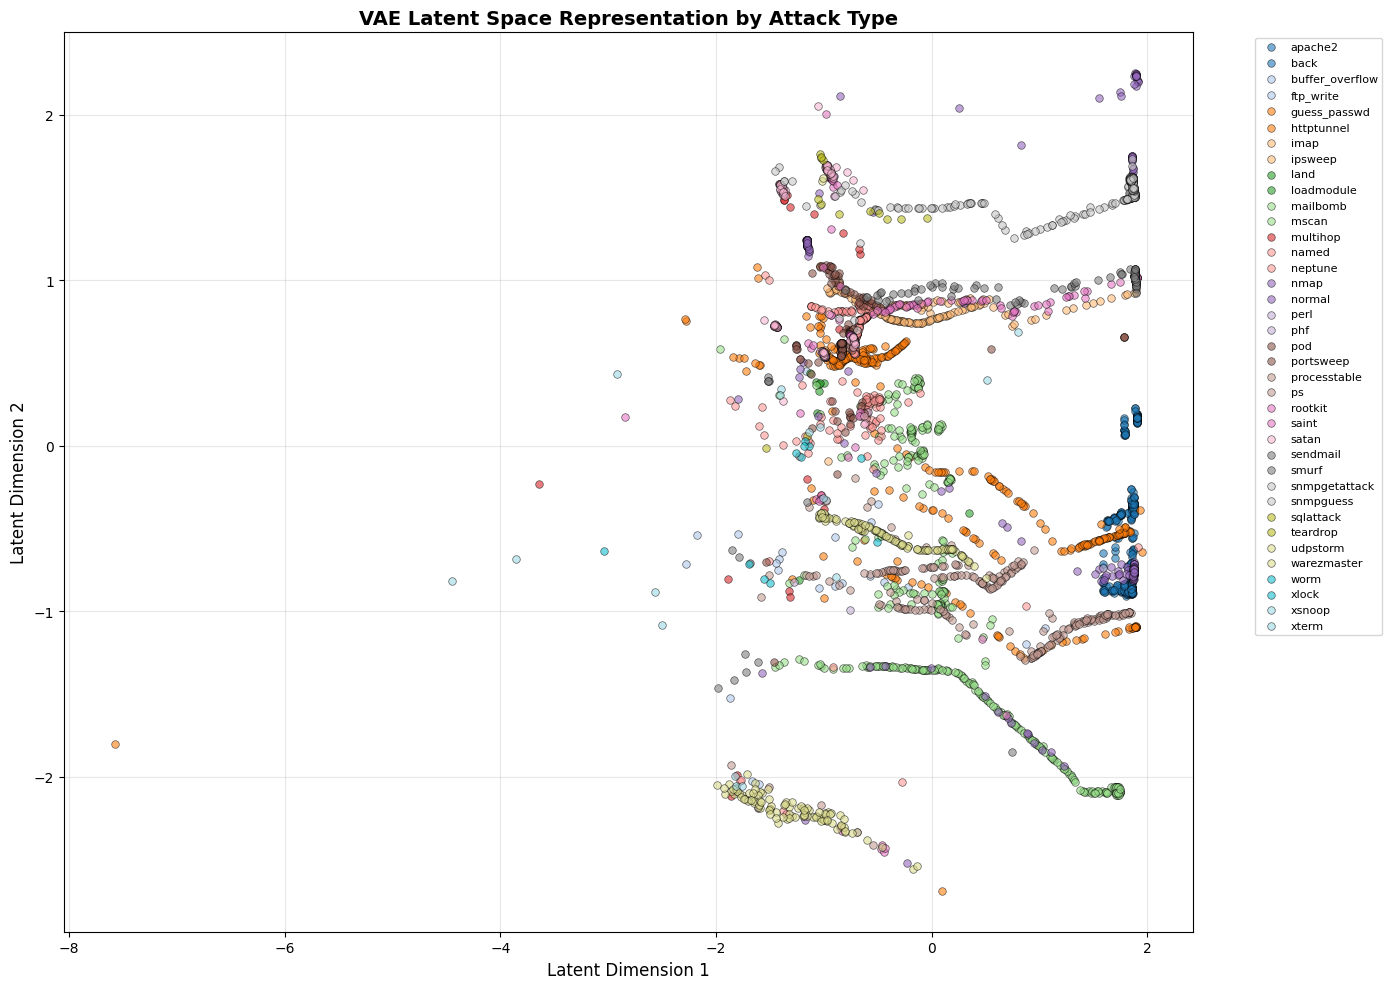

In [13]:
df_test = pd.read_csv("KDDTest+.txt", header=None)

attack_types = df_test[41].unique()
samples_per_type = 200

df_samples = []
for attack_type in attack_types:
    df_type = df_test[df_test[41] == attack_type]
    n_samples = min(samples_per_type, len(df_type))
    df_samples.append(df_type.sample(n_samples))

df_viz = pd.concat(df_samples, ignore_index=True)

viz_dataset = format_data(df_viz, proto_map, batch_size=32)

z_means = []
z_samples = []
labels = []

for batch_inputs, _ in viz_dataset:
    predictions = autoencoder.predict_on_batch(batch_inputs)
    z_means.append(predictions['z_mean'])

z_mean_all = np.concatenate(z_means, axis=0)
labels = df_viz[41].values

print(f"Latent space shape: {z_mean_all.shape}")
print(f"Number of samples: {len(labels)}")
print(f"Attack types: {np.unique(labels)}")

plt.figure(figsize=(14, 10))

unique_attacks = np.unique(labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_attacks)))

for i, attack in enumerate(unique_attacks):
    mask = labels == attack
    plt.scatter(
        z_mean_all[mask, 0],
        z_mean_all[mask, 1],
        c=[colors[i]],
        label=attack,
        alpha=0.6,
        s=30,
        edgecolors='black',
        linewidth=0.5
    )

plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.title('VAE Latent Space Representation by Attack Type', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()